# Time Series preprocessing
## Examples taken from:
    http://machinelearningmastery.com/time-series-data-visualization-with-python/
    https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/


In [20]:
%pylab inline
import pandas as pd
rcParams['figure.figsize'] = 15, 6

Populating the interactive namespace from numpy and matplotlib


#### Generate random time series

In [21]:
orig1 = pd.Series([sin(float(x)/20.)+rand()/2. for x in range(200)])
orig2 = pd.Series([1.5*sin(float(x)/20.)+rand()/2.+0.8 for x in range(200)])
orig1.describe()

count    200.000000
mean       0.442310
std        0.694661
min       -0.949759
25%       -0.053917
50%        0.540458
75%        1.050719
max        1.477651
dtype: float64

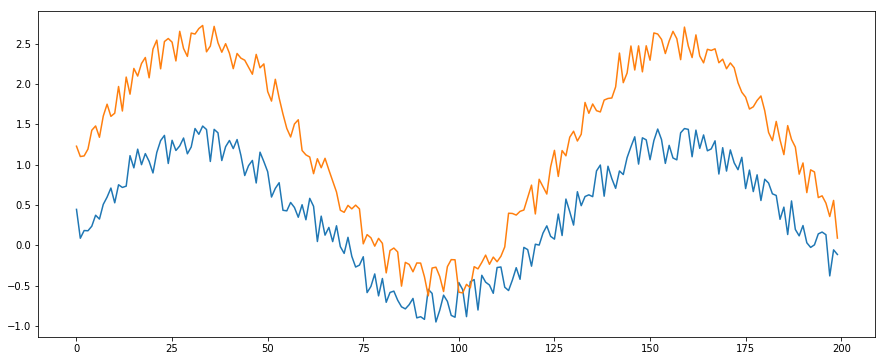

In [22]:
plot(orig1)
plot(orig2)

#### Transformation I: Offset Translation

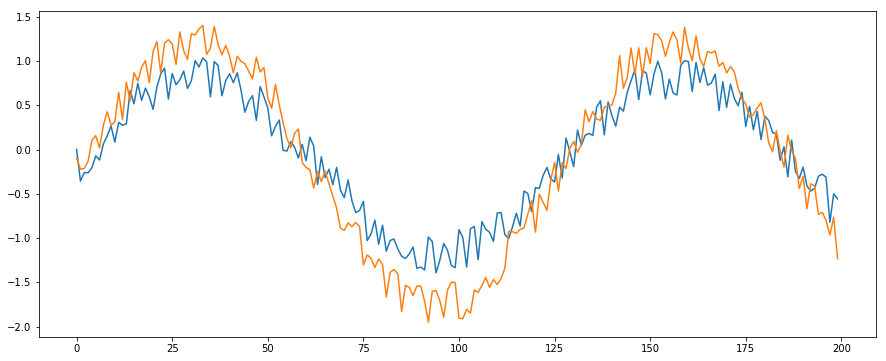

In [23]:
plot (orig1 - orig1.mean())
plot (orig2 - orig2.mean())

#### Transformation II: Amplitude Scaling

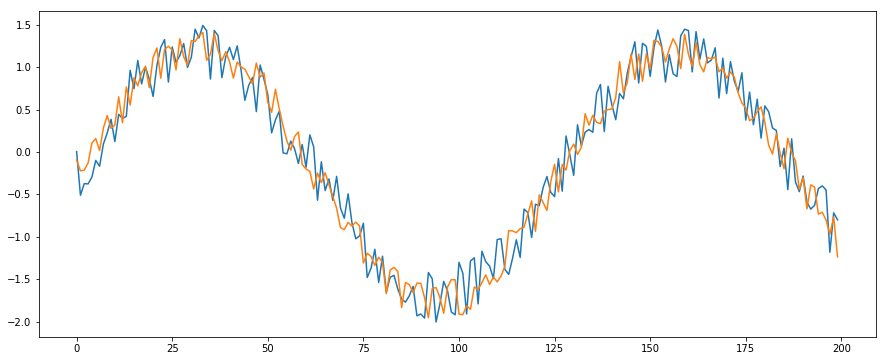

In [24]:
plot ( (orig1 - orig1.mean()) / orig1.std() ) 
plot ( (orig2 - orig2.mean()) / orig2.std() ) 


#### Transformation IV: Noise (smoothing)

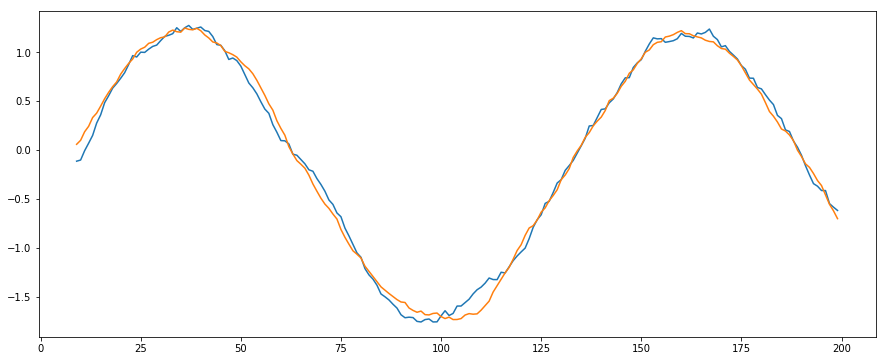

In [25]:
plot ( ( (orig1 - orig1.mean()) / orig1.std() ).rolling(window=10).mean() )
plot ( ( (orig2 - orig2.mean()) / orig2.std() ).rolling(window=10).mean() ) 

#### Experimenting trend removals on a more serious dataset: number of passengers for each date

Use Pandas functions for parsing dates

In [26]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=True, index_col='Month',date_parser=dateparse)
print data.head()

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [27]:
ts=data['#Passengers']

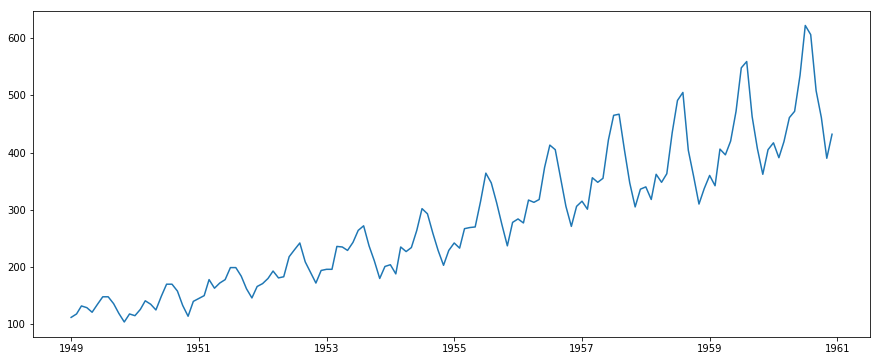

In [28]:
plt.plot(ts)

#### Transformation III: Trend removal
By smoothing with a very large window we obtain a (non-linear, non-parametric) trend line, that we can subtract to the original time series.

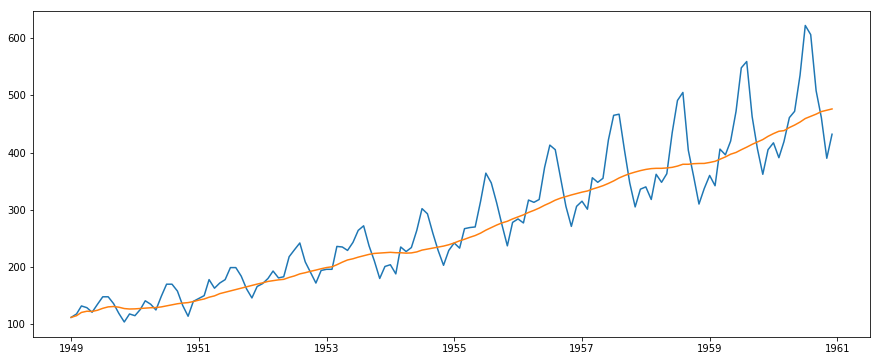

In [29]:
plt.plot(ts)
smooth = ts.rolling(window=12, min_periods=1).mean()
plt.plot(smooth)

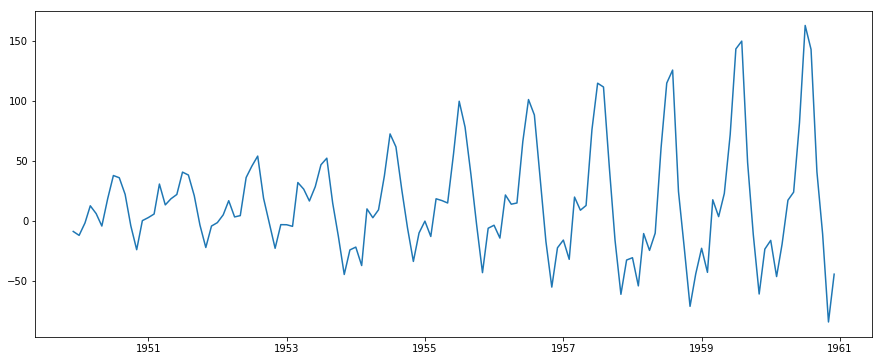

In [30]:
ts_shift = ts - ts.rolling(window=12).mean()
plt.plot( ts_shift )

#### Compare simple window smoothing with an exponential decay one (ewm)

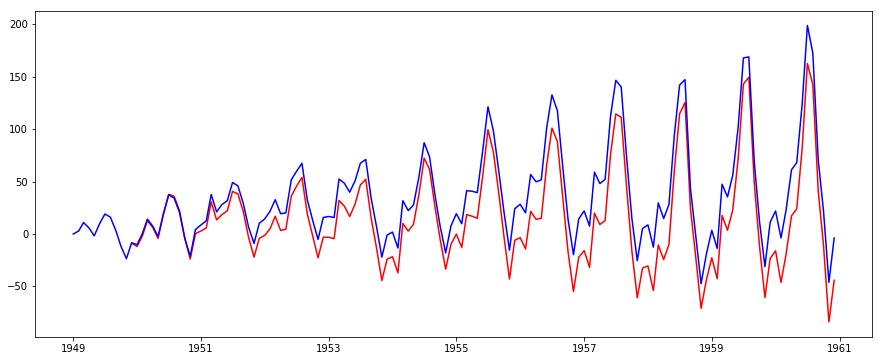

In [31]:
ts_shift2 = ts - ts.ewm(halflife=12).mean()
plt.plot( ts_shift, 'r-' )
plt.plot( ts_shift2, 'b-' )

## Sudying periodicity through Autocorrelation
Autocorrelation happens when the values of time series s are strongly correlated with the values observed earlier. Given a "lag" (time delay) L, we compute correlation between s(t) and s(t-L).

## Lag plot
Compare each value of s(t) (for all t) with the corresponding value of s(t-L). Default lag_plot function takes L=1.

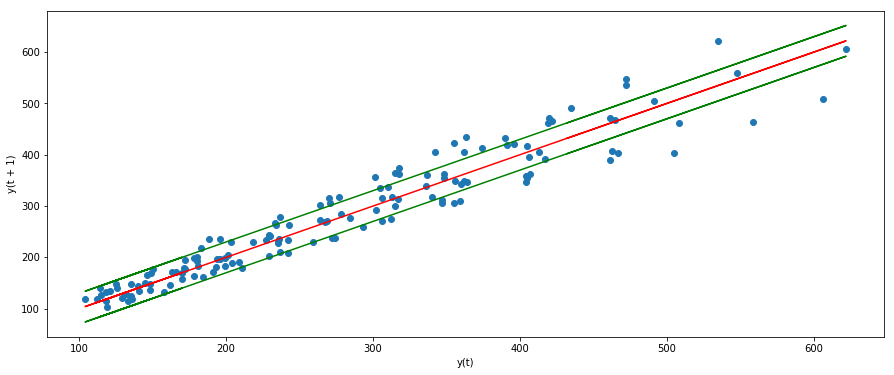

In [41]:
from pandas.plotting import lag_plot
lag_plot( ts )
# Plot also some reference lines to highlight strong correlation areas
plot(ts, ts, 'r-')
plot(ts, ts+30, 'g-')
plot(ts, ts-30, 'g-')

## Autocorrelation plot
Compute autocorrelation for all lag values and plot them. Values outside the drawn bounds (dashed lines) correspond to lags with high autocorrelation.

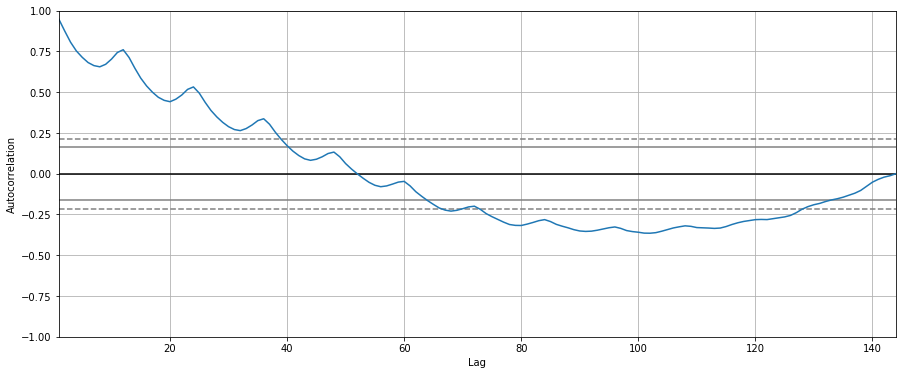

In [34]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts)

## Stationarity 
The Augmented Dickey-Fuller unit root test (http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).
Estimates whether the time series has a time-dependent structure (non-stationary, i.e. affected by trend, seasonality and other phenomena that make the statistics of the time series to vary in time) or not (stationary), which are related to (though quite different from) periodicity and autocorrelation.

In [35]:
from statsmodels.tsa.stattools import adfuller
ts_shift.dropna(inplace=True) # remove empty values due to rolling

result = adfuller(ts_shift)

print('ADF Statistic: %f' % result[0])
print('p-value: %f  (%s)' % (result[1], '< 0.05 => most likely stationary' if result[1]<0.05 \
                             else '> 0.05 => most likely non-stationary'))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f \t-->\t %s with error risk %s' % \
          (key, value, "periodic / non-stationary / autocorrelated" if result[0]>value \
           else "non-periodic / stationary / non-autocorrelated",key))

/home/leo/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ADF Statistic: -3.164968
p-value: 0.022104  (< 0.05 => most likely stationary)
Critical Values:
	5%: -2.886 	-->	 non-periodic / stationary / non-autocorrelated with error risk 5%
	1%: -3.487 	-->	 periodic / non-stationary / autocorrelated with error risk 1%
	10%: -2.580 	-->	 non-periodic / stationary / non-autocorrelated with error risk 10%


#### Another sample dataset

In [36]:
series = pd.Series.from_csv('daily-minimum-temperatures-in-me.csv', header=0)
series.head(10)

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
1981-01-06    15.8
1981-01-07    15.8
1981-01-08    17.4
1981-01-09    21.8
1981-01-10    20.0
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

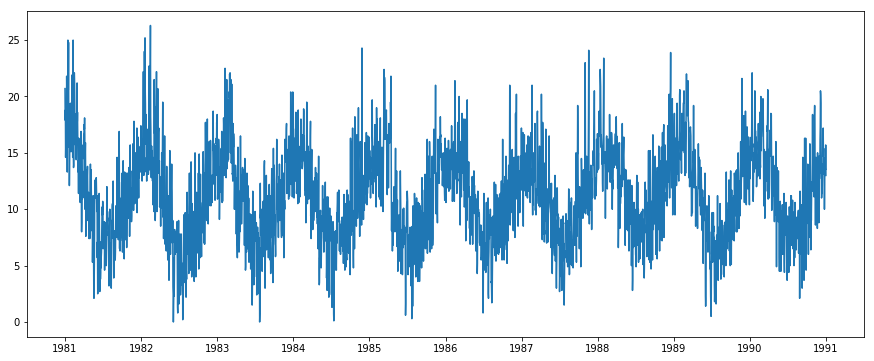

In [37]:
plot(series)

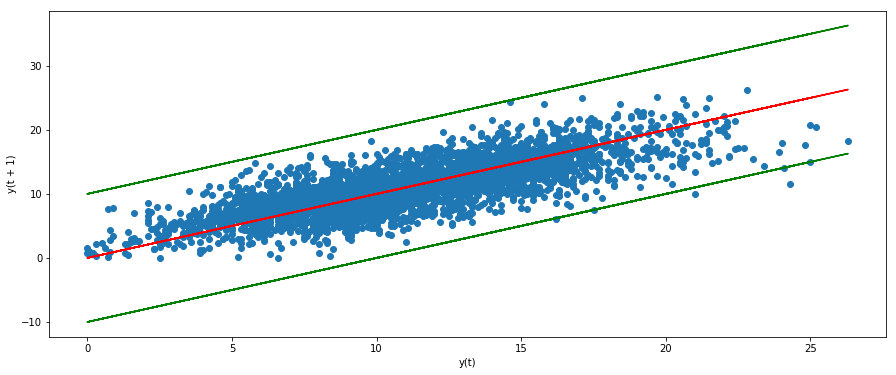

In [42]:
lag_plot( series )
# Plot also some reference lines to highlight strong correlation areas
plot(series, series, 'r-')
plot(series, series+10, 'g-')
plot(series, series-10, 'g-')

## Exploring seasonality with matrix plots
Use Pandas functions to split the (long) time series in several ones, one per year. Then plot them as heatmap, one year per line. Cold colors => low temperatures, hot colors => high temperatures.

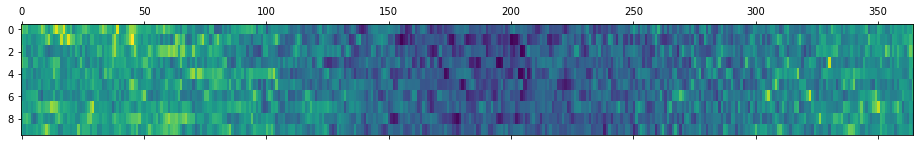

In [20]:
from pandas import TimeGrouper
from pandas import DataFrame
groups = series.groupby(TimeGrouper('A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
matshow(years.T, interpolation=None, aspect='auto')

#### Same as above, now splitting one year (1990) into months.

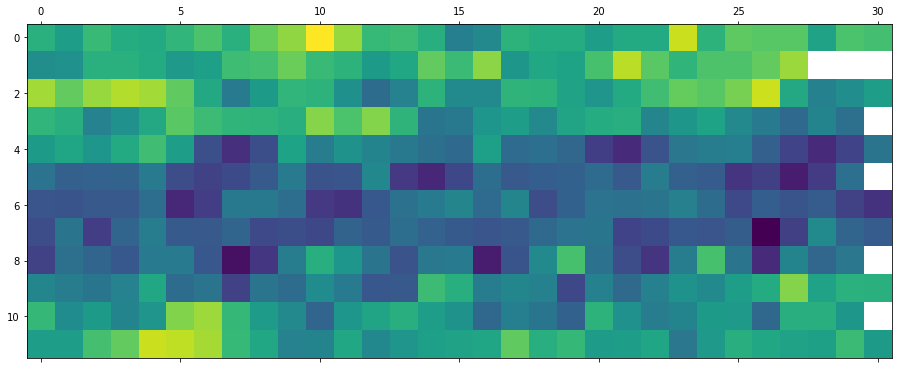

In [21]:
from pandas import concat
one_year = series['1990']
groups = one_year.groupby(TimeGrouper('M'))
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(1,13)
matshow(months.T, interpolation=None, aspect='auto')

## Make all tests on the full time series
Lag plot and autocorrelation plot suggest correlation, yet ADF test states stationarity -- autocorrelation does not affect the fact that the series has stable values.

/home/leo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  """Entry point for launching an IPython kernel.


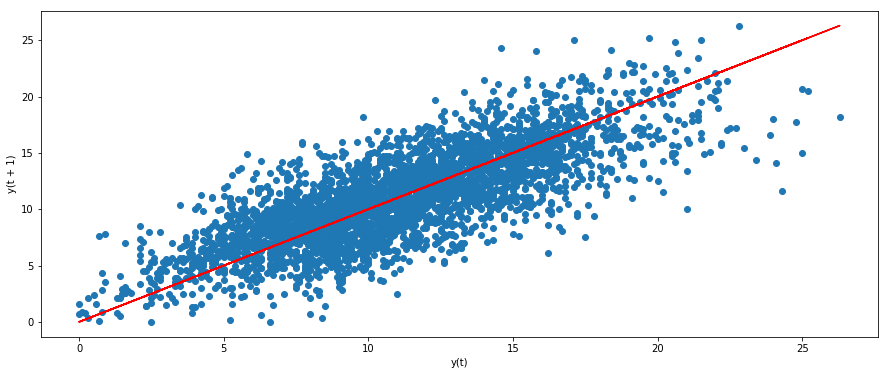

In [22]:
lag_plot( series )
plot(series, series, 'r-')

In [47]:
result = adfuller(series)

print('ADF Statistic: %f' % result[0])
print('p-value: %f  (%s)' % (result[1], '< 0.05 => most likely stationary' if result[1]<0.05 \
                             else '> 0.05 => most likely non-stationary'))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f \t-->\t %s with error risk %s' % \
          (key, value, "periodic / non-stationary / autocorrelated" if result[0]>value \
           else "non-periodic / stationary / non-autocorrelated",key))

ADF Statistic: -4.444805
p-value: 0.000247  (< 0.05 => most likely stationary)
Critical Values:
	5%: -2.862 	-->	 non-periodic / stationary / non-autocorrelated with error risk 5%
	1%: -3.432 	-->	 non-periodic / stationary / non-autocorrelated with error risk 1%
	10%: -2.567 	-->	 non-periodic / stationary / non-autocorrelated with error risk 10%


In [ ]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)

## What happens if we run the test on random data?
We expect that random data has no autocorrelation and is stationary (values do not depend on time).

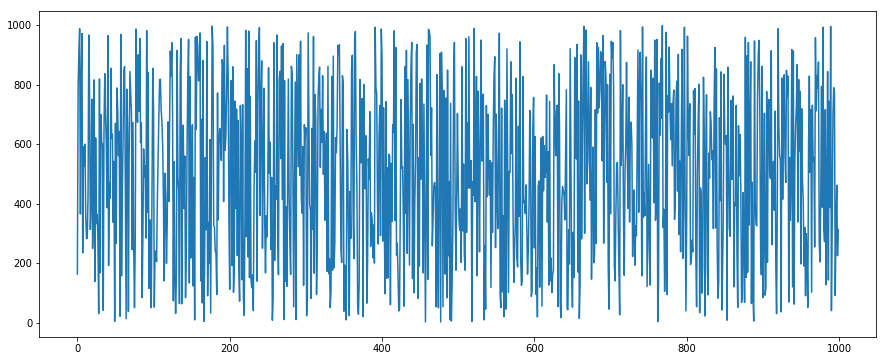

In [43]:
myrand = pd.Series(random.randint(0,1000) for i in range(1000))
plot(myrand)

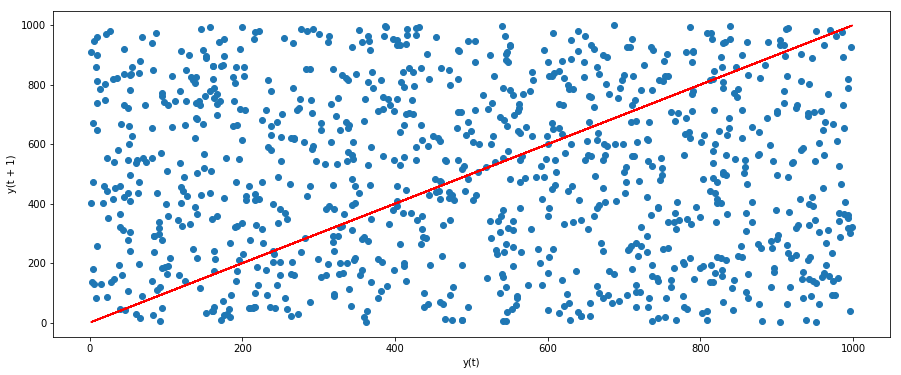

In [44]:
lag_plot(myrand)
plot(myrand, myrand, 'r-')

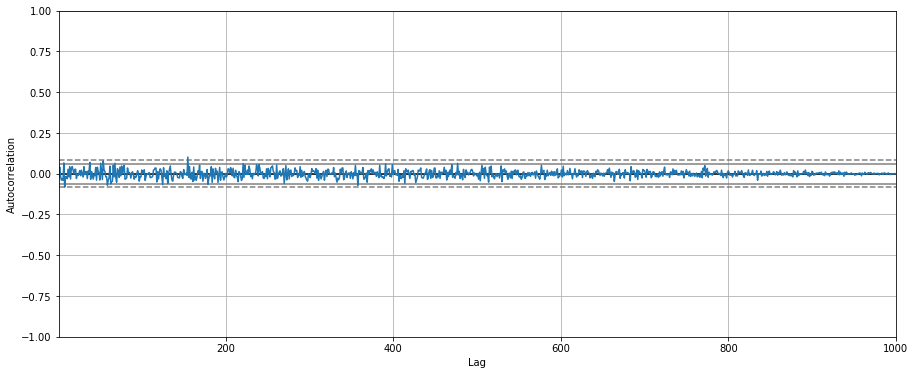

In [45]:
autocorrelation_plot(myrand)

In [46]:
result = adfuller(myrand)

print('ADF Statistic: %f' % result[0])
print('p-value: %f  (%s)' % (result[1], '< 0.05 => most likely stationary' if result[1]<0.05 \
                             else '> 0.05 => most likely non-stationary'))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f \t-->\t %s with error risk %s' % \
          (key, value, "periodic / non-stationary / autocorrelated" if result[0]>value \
           else "non-periodic / stationary / non-autocorrelated",key))

ADF Statistic: -12.158978
p-value: 0.000000  (< 0.05 => most likely stationary)
Critical Values:
	5%: -2.864 	-->	 non-periodic / stationary / non-autocorrelated with error risk 5%
	1%: -3.437 	-->	 non-periodic / stationary / non-autocorrelated with error risk 1%
	10%: -2.568 	-->	 non-periodic / stationary / non-autocorrelated with error risk 10%
